# 8장  
앞에서 사용한 트랜스포머 모델들에서 정확도 만으로는 성능이 좋다는 것을 확신할수없다.  
모델이 너무 느리거나 크다면 성능이 최고여도 의미없다.  
그 대안은 빠르고 작은 모델을 훈련하는 것이다. 하지만 모델이 작아지면 종종 성능이 저하된다.  
이 장에서는 예측 속도를 높이고 트랜스포머 모델의 메모리 사용량을 줄이는 기술 4가지를 공부한다.  
1. 지식 정제(knowledge distillation)  
2. 양자화(quantization)
3. 가지치기(pruning)
4. ONNX(Open Neural Network Exchange)포맷과 ONNX 런타임을 사용한 그래프 최적화  

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.41.2
Using datasets v2.20.0
Using accelerate v0.32.0
Using optuna v3.6.1
Using onnxruntime v1.18.1
Using onnx v1.16.1


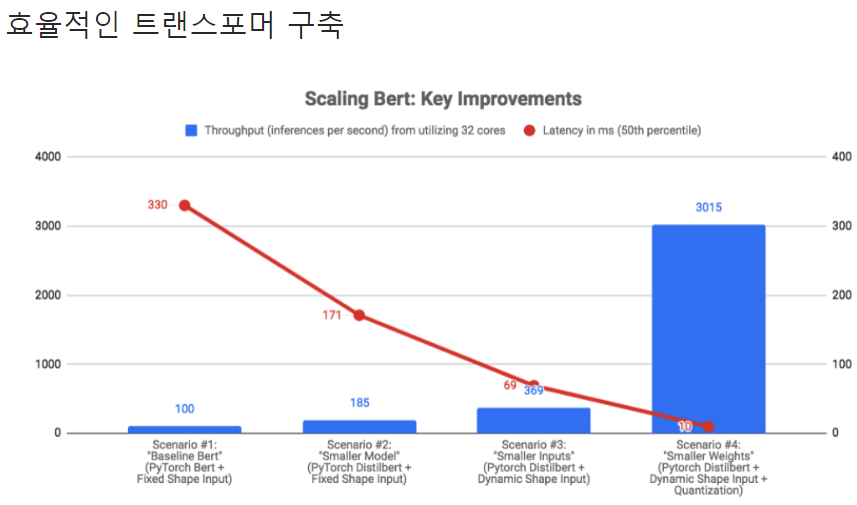

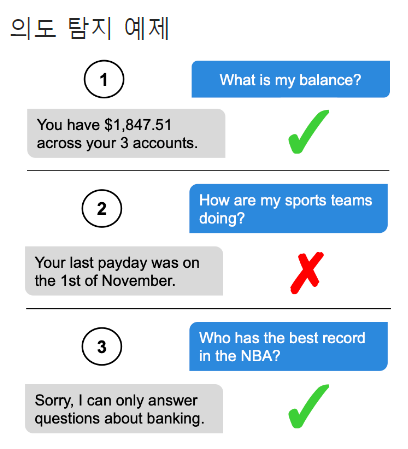

의도 탐지는 챗봇에서 중요한 구성요소이며 실시간 대화를 위해 레이턴시가 낮아야 한다.  
여기서는 CLINIC150이라는 데이터 셋을 사용한다. 그리고 이에 맞게 미세 튜닝한 BERT 모델을 사용  
이 데이터셋에는 150개의 의도와 은행, 여행등 10개의 분야로 분류된 쿼리 22500개가 존재.  
범위를 벗어난 쿼리도 1200개 존재 이건 OOS로 분류  

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036010742188}]

# 벤치마크 클래스 만들기  

1. 모델성능:모델 성능은 특히 오류가 발생했을 때 손실 비용이 큰 상황이나,수백만 개의 샘플에서  
추론을 실행해야 하므로 모델 지표가 조금 향상되면 전체적으로 큰 이득을 얻을 수 있는 상황에서 중요하다.  
2. 레이턴시:레이턴시는 보통 대량의 트랙픽을 처리하는 실시간 환경에서 고려합니다.  

3. 메모리는 모바일과 에지 장치에서 특별히 중요한 역할을 수행한다. 이 환경에서 모델이  
강력한 클라우드 서버에 접속하지 않고 예측을 만들어야한다.  



In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # 나중에 정의합니다
        pass

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [7]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")
'''
위에서 말한 데이터 셋 성능 확인하려고 미세 튜닝한 데이터 셋 가져옴
plus 는 범위 밖의 훈련 샘플이 담긴 서브셋을 의미
'''

'\n위에서 말한 데이터 셋 성능 확인하려고 미세 튜닝한 데이터 셋 가져옴\nplus 는 범위 바\n'

In [8]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [9]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [10]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


In [11]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [12]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy
#정확도 계산하는 함수
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [13]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [14]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}
#모델의 크기를 계산하는 함수
PerformanceBenchmark.compute_size = compute_size

In [15]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

'''
레이턴시 계산하는 방법
결과 차이가 심하니까 평균내는게 일반적
'''

레이턴시 (ms) - 297.494
레이턴시 (ms) - 215.934
레이턴시 (ms) - 223.526


In [16]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통계 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
#레이턴시 계산하는 함수
PerformanceBenchmark.time_pipeline = time_pipeline

'''
보통 레이턴시는 쿼리 길이에 따라 달라지므로 제품 환경에 마주하게 될 쿼리를 사용하는게 베스트'''

In [17]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 124.58 +\- 18.10
테스트 세트 정확도 - 0.867


# 지식 정제로 모델 크기 줄이기  
내가 알고있는 teacher-student 방식으로 이해 함.  
느리고 크지만 성능 좋은 선생 모델을 가져와 작은 학생 모델을 만들어서 선생 모델을  
모방 학습 하도록 진행  
사전 훈련하는 언어 모델의 파라미터 개수가 꾸준히 증가하는 경향을 고려할 때,  
지식 정제는 대규모 모델을 압축해 실용적으로 만들 수 있다.  

##미세 튜닝에서의 지식 정제  
미세 튜닝 같은 지도 학습 작업에서는 티처의 소프트 확률로 정답 레이블을 보강해서   
스튜던트가 학습할 때 부가 정보를 제공하는 것이 주요 아이디어이다.  
BERT 기반 분류기가 여러 개의 의도에 높은 확률을 할당한다면, 이 의도들은 특성 공간 안에서  
서로 가까이 위치한다는 신호일 가능성이 있다. 이런 확률을 모방하도록 스튜던트를 훈련해서  
티처가 학습한 '검은 지식'을 정제한다.  
> 검은 지식이란 레이블만으로는 얻지 못하는 지식입니다.  

만약 입력 시퀀스 x를 티처에 넣으면 출력이 로짓 z(x)로 나온다. 이에 소프트 맥스를 적용하면 다음 식이 나온다.  
$\frac{exp(z_i(x))}{\Sigma_j exp(z_i(x))}$  
하지만 티처는 대부분 한 클래스에 높은 확률을 할당하고 나머지는 거의 0에 가깝게 만든다.  
이 경우 티처는 정답 레이블 외에 추가 정보를 많이 제공하지 않는다.  
따라서 소프트맥스 함수를 적용하기 전에 온도 파라미터 T로 로짓의 스케일을 조정해  
확률을 소프트하게 만들어야 한다.  
$p_i(x)=\frac{exp(z_i(x)/T)}{\Sigma_j exp(z_i(x)/T)}$


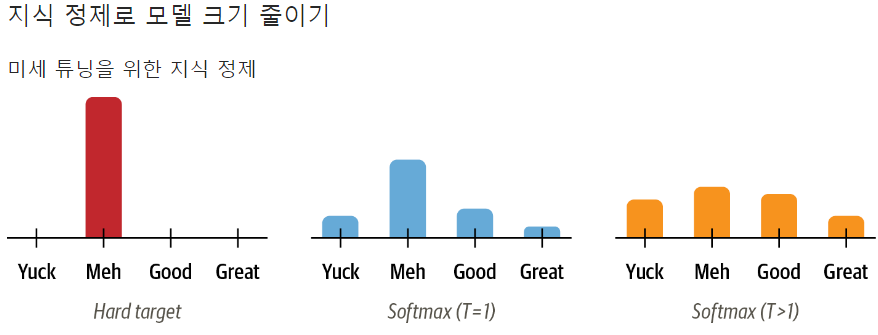

높은 T 값은 클래스에 대해 완만한 확률 분포를 만든다. 티처가 각 훈련 샘플로부터  
학습한 결정 경계에 대한 정보가 더 많이 드러난다.  
스튜던트도 자신의 소프트 확률 $q_i(x)$를 만들 수 있으므로 KL 발산을 사용해 두 분포의 차이를 측정한다.  
$D_{KL}(p,q)=Σ_i p_i(x) log\frac{p_i(x)}{q_i(x)} $  
KL 발산을 통해 티처의 확률분포를 스튜던트 분포에 근사해 손실되는 양을 계산한다.  
이를 통해 지식 정제 손실을 정의한다.  
$L_{KD}=T^2  D_{KL}$  
여기서 T는 위에서 T로 스케일 조정을 했으므로 그걸 고려한 정규화 인자이다.  
분류작업에서 스튜던트 손실은 정답에 대한 크로스 엔트로피 손실 $L_{CE}$로 정제 손실을 가중 평균 했다.  
$L_{student}=\alpha L_{CE}+(1-\alpha)L_{KD}$  
추론 시에는 (test 할때는) T를 1로 설정해서 원래 소프트 맥스 함수를 사용한다.

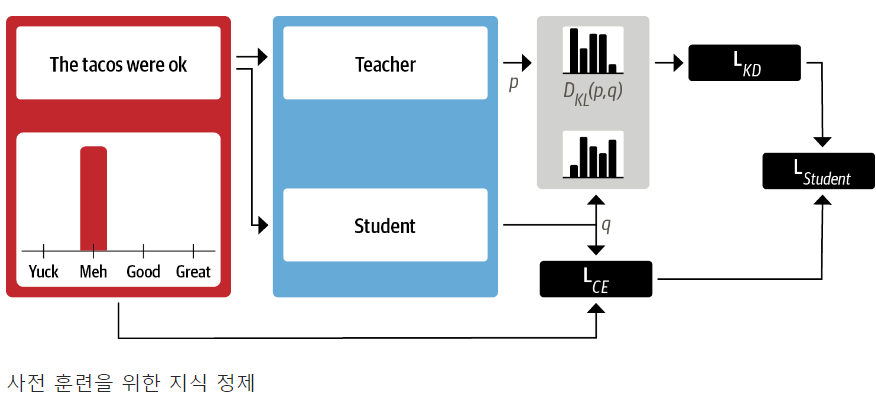

#사전 훈련에서의지식 정제  
사전 훈련하는 동안 후속 작업에서 미세 튜닝이 가능한 범용 스튜던트를 만들기 위해   
지식 정제를 사용할 수도 있다.  
이 경우 티처는 마스크드 언어 모델의 지식을 스튜던트에 전달하는 BERT 같은 사전 훈련된 언어 모델이다.  
DistilBERT는 마스크드 언어 모델링 손실$L_{mlm}$은 지식 정제 항과 티처와 스튜던트 간의 은닉 상채 벡터의  
방향을 정렬하기 위해 코사인 임베딩 손실$L_{cos}=1-cos(h_s,h_t)$로 보강된다.  
$L_{DistilBERT}=\alpha L_{mlm}+\beta L_{KD}+\gamma L_{cos}$  
우리는 미세튜닝된 BERT 기반 모델을 사용하므로 지식 정제를 사용해 더 작고 빠른 모델을 미세 튜닝하는 방법을 공부한다.

In [25]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

super().__init__(*args, **kwargs)는 부모 클래스인 TrainingArguments의 생성자를
호출하면서,  
전달받은 위치 인수(*args)와 키워드 인수(**kwargs)를 그대로 전달하여 초기화하겠다는 의미입니다.

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss